# Prediction of Life Expectancy Based on US States and Gender

In [119]:
# Import Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## Load and Inspect the Data

In [79]:
df = pd.read_csv('U.S._Life_Expectancy_at_Birth_by_State_and_Census_Tract_-_2010-2015.csv')
df2 = pd.read_csv('U.S._State_Life_Expectancy_by_Sex__2020.csv')

# Display the first few rows of each dataframe
print("First few rows of df:")
print(df.head())

print("\nFirst few rows of df2:")
print(df2.head())

# Display the summary information of each dataframe
print("\nInformation about df:")
print(df.info())

print("\nInformation about df2:")
print(df2.info())

# Display the columns of each dataframe
print("\nColumns in df:")
print(df.columns)

print("\nColumns in df2:")
print(df2.columns)

First few rows of df:
     State              County  Census Tract Number  Life Expectancy  \
0  Alabama             (blank)                  NaN             75.5   
1  Alabama  Autauga County, AL                201.0             73.1   
2  Alabama  Autauga County, AL                202.0             76.9   
3  Alabama  Autauga County, AL                203.0              NaN   
4  Alabama  Autauga County, AL                204.0             75.4   

  Life Expectancy Range  Life Expectancy Standard Error  
0             75.2-77.5                          0.0328  
1             56.9-75.1                          2.2348  
2             75.2-77.5                          3.3453  
3                   NaN                             NaN  
4             75.2-77.5                          1.0216  

First few rows of df2:
        State    Sex    LE     SE     Quartile
0     Alabama  Total  73.2  0.067  71.9 - 75.3
1      Alaska  Total  76.6  0.176  75.4 - 76.8
2     Arizona  Total  76.3  0.05

## Data Clean and Prep

In [80]:
# Check the columns in df
print("Columns in df:")
print(df.columns)

# Drop columns that are not needed for the prediction if they exist
columns_to_drop = ['Census Tract Number', 'State', 'County']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Drop columns that are not needed for the prediction in df2
if 'Quartile' in df2.columns:
    df2 = df2.drop(columns=['Quartile'])

# Handle missing values for numeric columns only
df = df.apply(lambda x: x.fillna(x.mean()) if x.dtype.kind in 'biufc' else x)
df2 = df2.apply(lambda x: x.fillna(x.mean()) if x.dtype.kind in 'biufc' else x)

# Encode categorical variables if necessary (e.g., Sex)
df2['Sex'] = df2['Sex'].map({'Male': 0, 'Female': 1, 'Total': 2})

Columns in df:
Index(['State', 'County', 'Census Tract Number', 'Life Expectancy',
       'Life Expectancy Range', 'Life Expectancy Standard Error'],
      dtype='object')


## Inferential Statistics

In [81]:
print(df.describe, df2.describe())

<bound method NDFrame.describe of        Life Expectancy Life Expectancy Range  Life Expectancy Standard Error
0            75.500000             75.2-77.5                        0.032800
1            73.100000             56.9-75.1                        2.234800
2            76.900000             75.2-77.5                        3.345300
3            78.309823                   NaN                        1.854457
4            75.400000             75.2-77.5                        1.021600
...                ...                   ...                             ...
73116        80.100000             79.6-81.6                        2.691600
73117        79.900000             79.6-81.6                        2.802400
73118        81.800000             81.7-97.5                        2.077600
73119        79.000000             77.6-79.5                        1.069700
73120        78.600000             77.6-79.5                        1.609300

[73121 rows x 3 columns]>               S

In [82]:
print(df.value_counts())
print(df2.value_counts())

Life Expectancy  Life Expectancy Range  Life Expectancy Standard Error
73.9             56.9-75.1              1.6349                            3
80.0             79.6-81.6              1.4231                            3
75.9             75.2-77.5              1.4056                            3
77.8             77.6-79.5              1.4503                            3
78.2             77.6-79.5              1.0645                            3
                                                                         ..
76.8             75.2-77.5              1.5881                            1
                                        1.5889                            1
                                        1.5925                            1
                                        1.5941                            1
97.5             81.7-97.5              3.5269                            1
Name: count, Length: 66291, dtype: int64
State           Sex  LE    SE   
Alabama         0  

In [83]:
# Check for missing values (null)
print(df.isnull().sum()) 
print(df2.isnull().sum())

Life Expectancy                      0
Life Expectancy Range             5922
Life Expectancy Standard Error       0
dtype: int64
State    0
Sex      0
LE       0
SE       0
dtype: int64


In [84]:
# Define a function to detect outliers using IQR
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = data[(data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))]
    return outliers

# Detect outliers in the 'Life Expectancy' column of df and the 'LE' column of df2
outliers_df = detect_outliers_iqr(df['Life Expectancy'])
outliers_df2 = detect_outliers_iqr(df2['LE'])

print("Outliers in df using IQR:\n", outliers_df)
print("Outliers in df2 using IQR:\n", outliers_df2)

# Define a function to detect outliers using Z-score
def detect_outliers_zscore(data):
    z_scores = stats.zscore(data)
    abs_z_scores = np.abs(z_scores)
    outliers = data[abs_z_scores > 3]
    return outliers

# Detect outliers in the 'Life Expectancy' column of df and the 'LE' column of df2
outliers_df_z = detect_outliers_zscore(df['Life Expectancy'])
outliers_df2_z = detect_outliers_zscore(df2['LE'])

print("Outliers in df using Z-score:\n", outliers_df_z)
print("Outliers in df2 using Z-score:\n", outliers_df2_z)

Outliers in df using IQR:
 80       67.1
83       68.3
85       67.8
91       67.9
101      68.1
         ... 
72538    88.2
72591    68.9
72915    67.7
73019    88.9
73032    92.5
Name: Life Expectancy, Length: 1544, dtype: float64
Outliers in df2 using IQR:
 Series([], Name: LE, dtype: float64)
Outliers in df using Z-score:
 299      66.8
300      65.3
397      66.8
399      66.7
404      66.6
         ... 
71369    64.1
71505    60.4
71548    65.3
72415    65.9
73032    92.5
Name: Life Expectancy, Length: 424, dtype: float64
Outliers in df2 using Z-score:
 Series([], Name: LE, dtype: float64)


## Exploratory Data Analysis

Sex
Other     52
Male      52
Female    52
Name: count, dtype: int64


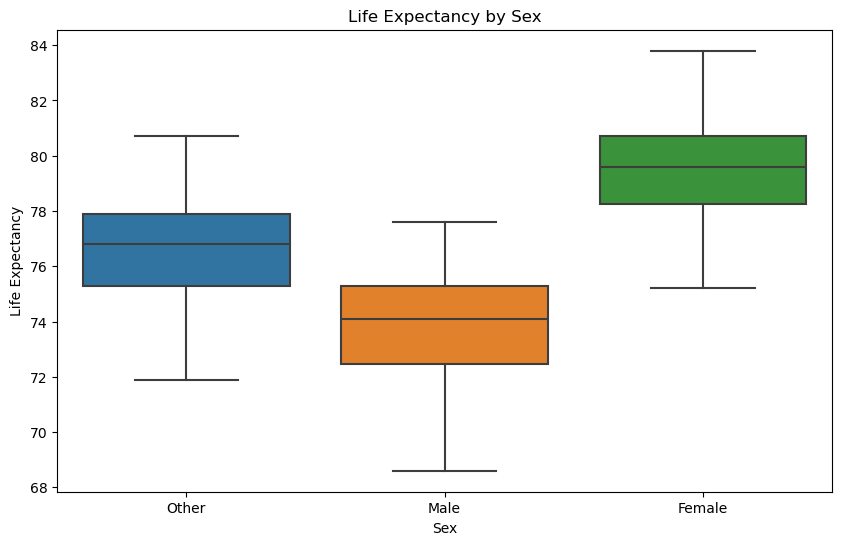

In [113]:
# Assuming 0 represents 'Male', 1 represents 'Female', and 2 represents 'Other'
sex_mapping = {0: 'Male', 1: 'Female', 2: 'Other'}

# Map the 'Sex' column to more readable labels
df2['Sex'] = df2['Sex'].map(sex_mapping)

# Verify the mapping
print(df2['Sex'].value_counts())

# Plot the box plot again with readable labels
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sex', y='LE', data=df2)
plt.title('Life Expectancy by Sex')
plt.xlabel('Sex')
plt.ylabel('Life Expectancy')
plt.show()

/Users/busyness/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


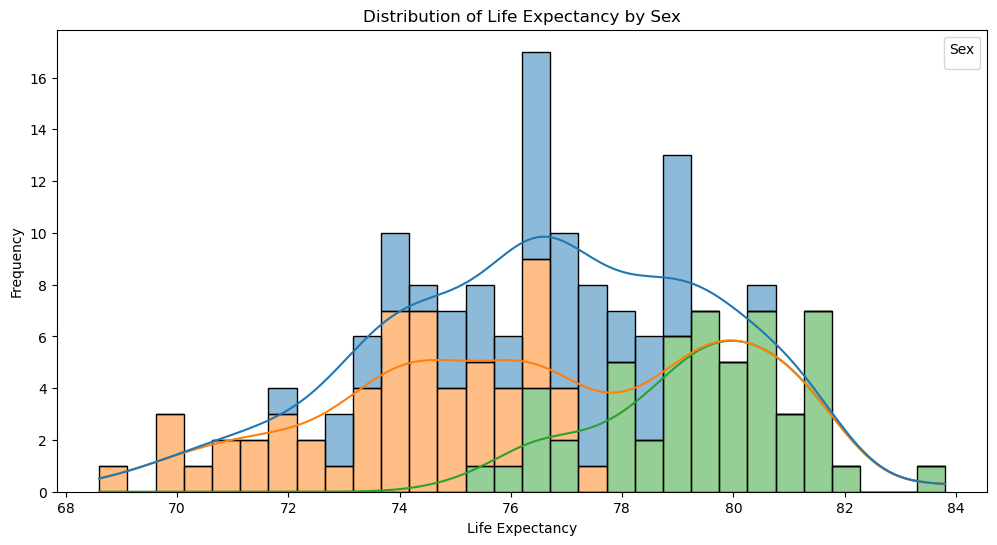

In [114]:
# Distribution Plot of Life Expectancy by Sex
plt.figure(figsize=(12, 6))
sns.histplot(data=df2, x='LE', hue='Sex', kde=True, bins=30, multiple='stack')
plt.title('Distribution of Life Expectancy by Sex')
plt.xlabel('Life Expectancy')
plt.ylabel('Frequency')
plt.legend(title='Sex')
plt.show()

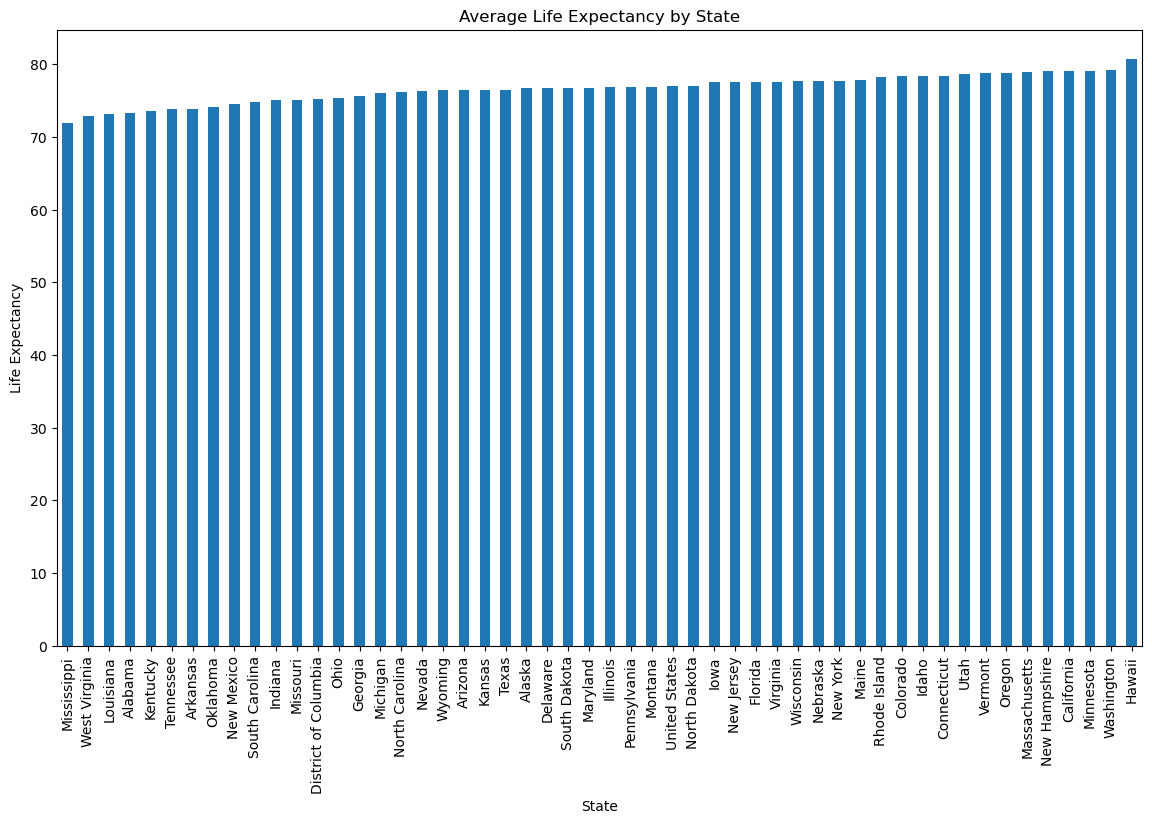

In [87]:
# Life Expectancy by State (Bar Plot)
plt.figure(figsize=(14, 8))
df_state = df2.groupby('State')['LE'].mean().sort_values()
df_state.plot(kind='bar')
plt.title('Average Life Expectancy by State')
plt.xlabel('State')
plt.ylabel('Life Expectancy')
plt.xticks(rotation=90)
plt.show()

<Figure size 1800x800 with 0 Axes>

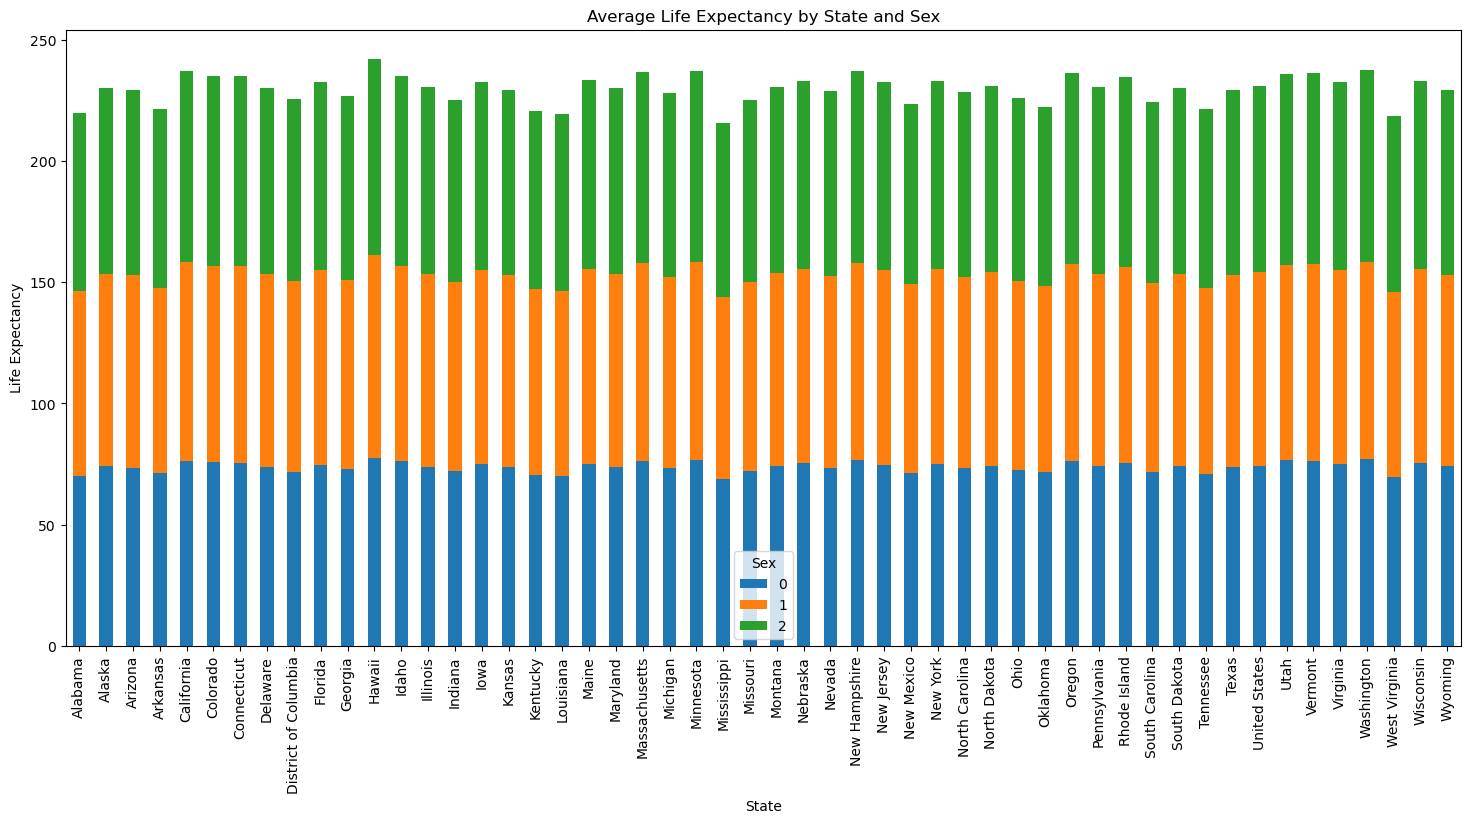

In [105]:
# Average Life Expectancy by State and Sex (Bar Plot)
plt.figure(figsize=(18, 8))
df_state_sex = df2.groupby(['State', 'Sex'])['LE'].mean().unstack()
df_state_sex.plot(kind='bar', stacked=True, figsize=(18, 8))
plt.title('Average Life Expectancy by State and Sex')
plt.xlabel('State')
plt.ylabel('Life Expectancy')
plt.xticks(rotation=90)
plt.legend(title='Sex')
plt.show()

[2 0 1]


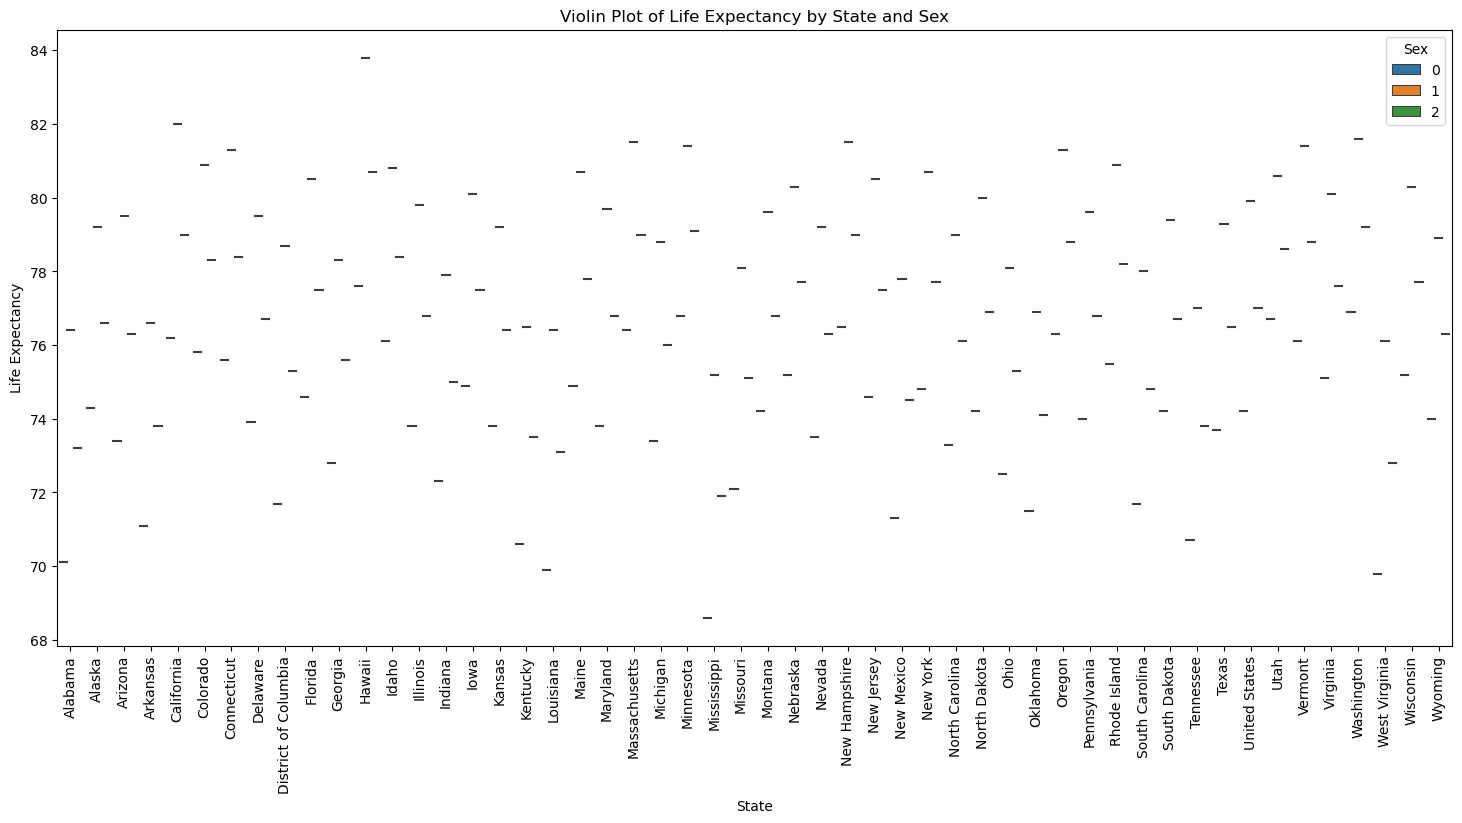

In [106]:
# Check the unique values in the 'Sex' column
print(df2['Sex'].unique())

# Violin Plot of Life Expectancy by State and Sex
plt.figure(figsize=(18, 8))
sns.violinplot(x='State', y='LE', hue='Sex', data=df2)
plt.title('Violin Plot of Life Expectancy by State and Sex')
plt.xlabel('State')
plt.ylabel('Life Expectancy')
plt.xticks(rotation=90)
plt.legend(title='Sex')
plt.show()

/Users/busyness/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/busyness/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


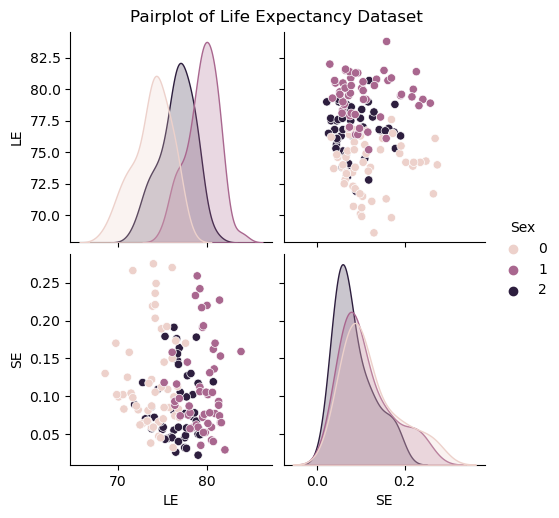

In [110]:
# Pairplot
sns.pairplot(df2.select_dtypes(include=['float64', 'int64']), hue='Sex', diag_kind='kde')
plt.suptitle('Pairplot of Life Expectancy Dataset', y=1.02)
plt.show()

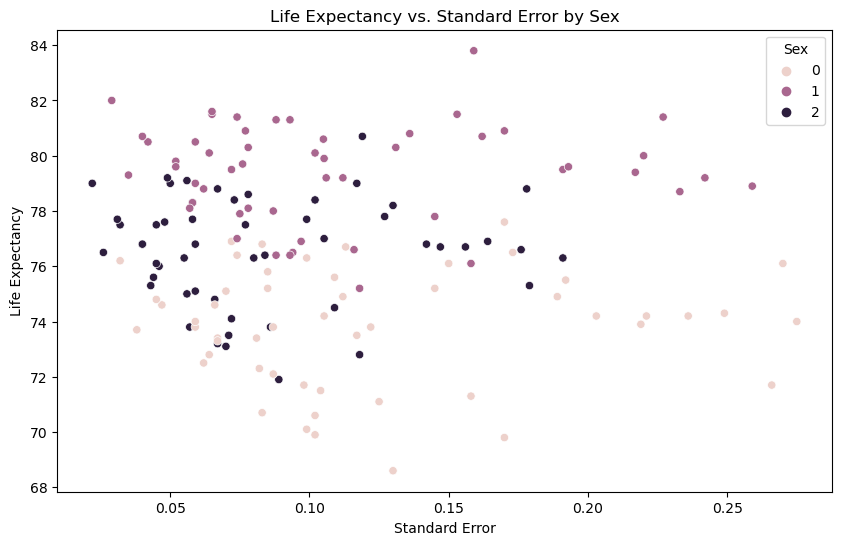

In [94]:
# Life Expectancy vs. Standard Error by Sex (Scatter Plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='SE', y='LE', hue='Sex', data=df2)
plt.title('Life Expectancy vs. Standard Error by Sex')
plt.xlabel('Standard Error')
plt.ylabel('Life Expectancy')
plt.show()

## Data Split

In [95]:
# Separate features and target variable in df2
X = df2[['State', 'Sex']]
y = df2['LE']

# Perform one-hot encoding on the 'State' column
X = pd.get_dummies(X, columns=['State'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Linear Regression Model

In [96]:
# Initialize and train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression Mean Squared Error: {mse}")
print(f"Linear Regression R-squared: {r2}")

Linear Regression Mean Squared Error: 10.073522422015667
Linear Regression R-squared: 0.1107879191081712


## Random Forest Regression Model

In [97]:
# Initialize and train a Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set with Random Forest
y_pred_rf = rf_model.predict(X_test)

# Evaluate the Random Forest model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Mean Squared Error: {mse_rf}")
print(f"Random Forest R-squared: {r2_rf}")

Random Forest Mean Squared Error: 5.785730468749962
Random Forest R-squared: 0.48928078838117384


## Hyperparameter Tuning with Grid Search for Random Forest

In [98]:
# Optional: Hyperparameter tuning with GridSearchCV for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=5, n_jobs=1, verbose=2)
grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_

# Predict on the test set with the best Random Forest model
y_pred_best_rf = best_rf_model.predict(X_test)

# Evaluate the best Random Forest model
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print(f"Best Random Forest Mean Squared Error: {mse_best_rf}")
print(f"Best Random Forest R-squared: {r2_best_rf}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ....................max_depth=None, n_estimators=50; total time=   0.1s
[CV] END ....................max_depth=None, n_estimators=50; total time=   0.1s
[CV] END ....................max_depth=None, n_estimators=50; total time=   0.1s
[CV] END ....................max_depth=None, n_estimators=50; total time=   0.1s
[CV] END ....................max_depth=None, n_estimators=50; total time=   0.1s
[CV] END ...................max_depth=None, n_estimators=100; total time=   0.1s
[CV] END ...................max_depth=None, n_estimators=100; total time=   0.2s
[CV] END ...................max_depth=None, n_estimators=100; total time=   0.1s
[CV] END ...................max_depth=None, n_estimators=100; total time=   0.2s
[CV] END ...................max_depth=None, n_estimators=100; total time=   0.2s
[CV] END ...................max_depth=None, n_estimators=200; total time=   0.3s
[CV] END ...................max_depth=None, n_es

In [99]:
# Save the best Random Forest model
joblib.dump(best_rf_model, 'best_random_forest_model.pkl')

['best_random_forest_model.pkl']

In [100]:
# Predict life expectancy based on gender and state
def predict_life_expectancy(state, gender):
    # Encode the input variables
    gender_code = {'Male': 0, 'Female': 1, 'Total': 2}[gender]
    input_data = pd.DataFrame({
        'Sex': [gender_code],
        'State_' + state: [1]  # One-hot encoding for the state
    })
    
    # Ensure all state columns are present
    for col in X.columns:
        if col not in input_data.columns:
            input_data[col] = 0

    # Reorder columns to match training data
    input_data = input_data[X.columns]

    # Predict and return life expectancy
    prediction = best_rf_model.predict(input_data)
    return prediction[0]

# Example: Predict life expectancy for Female in California
states = df2['State'].unique()
genders = ['Male', 'Female', 'Total']

for state in states:
    for gender in genders:
        prediction = predict_life_expectancy(state, gender)
        print(f"Predicted life expectancy in {state} for {gender}: {prediction:.2f} years")

Predicted life expectancy in Alabama for Male: 71.86 years
Predicted life expectancy in Alabama for Female: 80.07 years
Predicted life expectancy in Alabama for Total: 74.55 years
Predicted life expectancy in Alaska for Male: 74.49 years
Predicted life expectancy in Alaska for Female: 80.05 years
Predicted life expectancy in Alaska for Total: 76.90 years
Predicted life expectancy in Arizona for Male: 74.35 years
Predicted life expectancy in Arizona for Female: 80.07 years
Predicted life expectancy in Arizona for Total: 76.90 years
Predicted life expectancy in Arkansas for Male: 74.49 years
Predicted life expectancy in Arkansas for Female: 78.18 years
Predicted life expectancy in Arkansas for Total: 75.12 years
Predicted life expectancy in California for Male: 75.03 years
Predicted life expectancy in California for Female: 80.89 years
Predicted life expectancy in California for Total: 77.73 years
Predicted life expectancy in Colorado for Male: 74.56 years
Predicted life expectancy in Co

Predicted life expectancy in Utah for Female: 80.09 years
Predicted life expectancy in Utah for Total: 76.90 years
Predicted life expectancy in Vermont for Male: 74.49 years
Predicted life expectancy in Vermont for Female: 80.31 years
Predicted life expectancy in Vermont for Total: 77.52 years
Predicted life expectancy in Virginia for Male: 74.49 years
Predicted life expectancy in Virginia for Female: 80.07 years
Predicted life expectancy in Virginia for Total: 76.90 years
Predicted life expectancy in Washington for Male: 75.74 years
Predicted life expectancy in Washington for Female: 80.07 years
Predicted life expectancy in Washington for Total: 78.18 years
Predicted life expectancy in West Virginia for Male: 74.49 years
Predicted life expectancy in West Virginia for Female: 77.85 years
Predicted life expectancy in West Virginia for Total: 73.99 years
Predicted life expectancy in Wisconsin for Male: 74.49 years
Predicted life expectancy in Wisconsin for Female: 80.07 years
Predicted l

In [101]:
# Predict overall life expectancy for males and females accumulatively
def predict_overall_life_expectancy(sex):
    # Encode the input variable
    gender_code = {'Male': 0, 'Female': 1}[sex]
    predictions = []
    states = df2['State'].unique()
    
    for state in states:
        input_data = pd.DataFrame({
            'Sex': [gender_code],
            'State_' + state: [1]  # One-hot encoding for the state
        })
        
        # Ensure all state columns are present
        for col in X.columns:
            if col not in input_data.columns:
                input_data[col] = 0

        # Reorder columns to match training data
        input_data = input_data[X.columns]

        # Predict and collect life expectancy
        prediction = best_rf_model.predict(input_data)
        predictions.append(prediction[0])
    
    # Calculate and return average life expectancy
    avg_life_expectancy = sum(predictions) / len(predictions)
    return avg_life_expectancy

# Predict and print average life expectancy for males and females
male_life_expectancy = predict_overall_life_expectancy('Male')
female_life_expectancy = predict_overall_life_expectancy('Female')

print(f"Overall predicted life expectancy for males: {male_life_expectancy:.2f} years")
print(f"Overall predicted life expectancy for females: {female_life_expectancy:.2f} years")

Overall predicted life expectancy for males: 74.33 years
Overall predicted life expectancy for females: 79.76 years


In [102]:
# Calculate and print the percentage difference
percentage_difference = ((female_life_expectancy - male_life_expectancy) / male_life_expectancy) * 100
print(f"Percentage difference between female and male life expectancy: {percentage_difference:.2f}%")

Percentage difference between female and male life expectancy: 7.31%


In [121]:
# Load the dataset and the trained model
best_rf_model = joblib.load('best_random_forest_model.pkl')

# Assuming 0 represents 'Male', 1 represents 'Female', and 2 represents 'Other'
sex_mapping = {0: 'Male', 1: 'Female', 2: 'Other'}
df2['Sex'] = df2['Sex'].map(sex_mapping)

# Prepare the data for prediction
X = df2[['State', 'Sex']]
X = pd.get_dummies(X, columns=['State'])

# Function to predict life expectancy for a given state and gender
def predict_life_expectancy(state, gender):
    gender_code = {'Male': 0, 'Female': 1, 'Other': 2}[gender]
    input_data = pd.DataFrame({'Sex': [gender_code], 'State_' + state: [1]})
    
    for col in X.columns:
        if col not in input_data.columns:
            input_data[col] = 0
    
    input_data = input_data[X.columns]
    prediction = best_rf_model.predict(input_data)
    return prediction[0]

# Predict life expectancy for all states and both genders
states = df2['State'].unique()
genders = ['Male', 'Female']

predictions = {'State': [], 'Gender': [], 'Life Expectancy': []}

for state in states:
    for gender in genders:
        life_expectancy = predict_life_expectancy(state, gender)
        predictions['State'].append(state)
        predictions['Gender'].append(gender)
        predictions['Life Expectancy'].append(life_expectancy)

predictions_df = pd.DataFrame(predictions)

# Find the top 5 states with the highest life expectancy for males and females
top_5_male = predictions_df[predictions_df['Gender'] == 'Male'].nlargest(5, 'Life Expectancy')
top_5_female = predictions_df[predictions_df['Gender'] == 'Female'].nlargest(5, 'Life Expectancy')

print("Top 5 states with the highest life expectancy for males:")
print(top_5_male)

print("\nTop 5 states with the highest life expectancy for females:")
print(top_5_female)

Top 5 states with the highest life expectancy for males:
            State Gender  Life Expectancy
22         Hawaii   Male        76.890129
96     Washington   Male        75.737233
46      Minnesota   Male        75.619543
58  New Hampshire   Male        75.421887
74         Oregon   Male        75.217810

Top 5 states with the highest life expectancy for females:
            State  Gender  Life Expectancy
23         Hawaii  Female        82.459232
9      California  Female        80.894017
59  New Hampshire  Female        80.323561
93        Vermont  Female        80.305159
75         Oregon  Female        80.183412
